In [1]:
import os
# 设置环境变量
os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4"

To 老师 and T.A. 本实验是在linux环境下训练的，由于不要求上传预训练模型与数据集，可能不便于复现，故我也没有修改文件路径为相对路径。

## 对更新过的数据集采用5折交叉验证

In [19]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score,f1_score
from transformers import Trainer,TrainingArguments
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.special import softmax
import matplotlib.pyplot as plt
 
tokenizer = AutoTokenizer.from_pretrained("/root/pretrained_llm/deberta-v3-large")
essay = load_dataset('csv',data_files="/root/Mcqueen/kaggle_c/dataset/persuade_origin.csv")

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [20]:
essay=essay["train"]
print(essay)

Dataset({
    features: ['essay_id', 'full_text', 'score'],
    num_rows: 30432
})


In [5]:
kf = KFold(n_splits=5,shuffle=True,random_state=2021)

def tokenize_function(batch):
    encoding = tokenizer(batch["full_text"],truncation=True, max_length=1024)
    return {
        "input_ids":encoding["input_ids"],
        "attention_mask":encoding["attention_mask"],
        "label":list(map(lambda x: x-1,batch["score"]))
    }


In [11]:
for i, (train_index, val_index) in enumerate(kf.split(essay)):
    if i == 2:
        print("train_index", train_index[:50], "\nval_index", val_index[:50])

train_index [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 22 23 24 25 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 51 52 53 54
 55 56] 
val_index [  0  12  21  26  37  38  50  67  70  81  83  91  99 109 113 124 125 127
 135 136 141 145 148 152 155 156 162 166 168 169 176 177 189 193 194 196
 202 203 212 213 214 217 240 246 250 258 272 274 276 283]


In [13]:
import pandas as pd

oof = pd.DataFrame()
oof["id"]=essay["essay_id"]
print(oof["id"][1])

000fe60


In [14]:
for i in range(1, 7):
    oof = oof.assign(**{f'score_{i}': 0})
print(oof)

                 id  score_1  score_2  score_3  score_4  score_5  score_6
0           000d118        0        0        0        0        0        0
1           000fe60        0        0        0        0        0        0
2           001ab80        0        0        0        0        0        0
3           001bdc0        0        0        0        0        0        0
4           002ba53        0        0        0        0        0        0
...             ...      ...      ...      ...      ...      ...      ...
30427  18409261F5C2        0        0        0        0        0        0
30428  D46BCB48440A        0        0        0        0        0        0
30429  0FB0700DAF44        0        0        0        0        0        0
30430  D72CB1C11673        0        0        0        0        0        0
30431  DF920E0A7337        0        0        0        0        0        0

[30432 rows x 7 columns]


Map: 100%|██████████| 24346/24346 [00:07<00:00, 3147.08 examples/s]


Fold: 5


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


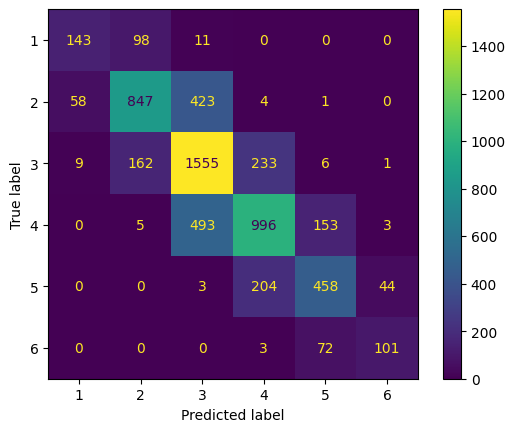

In [24]:
#验证第i折的效果

for i, (train_index, val_index) in enumerate(kf.split(essay)):

    if i < 4:
        continue

    model = AutoModelForSequenceClassification.from_pretrained("/root/Mcqueen/kaggle_c/output_5/checkpoint-1900",num_labels=6)
    train_dataset = essay.select(train_index)
    val_dataset = essay.select(val_index)
    train_dataset = train_dataset.map(tokenize_function,batched=True)
    val_dataset = val_dataset.map(tokenize_function,batched=True)

    print("Fold:",i+1)
    output_dir_template="/root/Mcqueen/kaggle_c/output_{}"
    logging_dir_template="/root/Mcqueen/kaggle_c/logs_{}"

    training_args = TrainingArguments(
        output_dir = output_dir_template.format(i+1),
        num_train_epochs=10,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=8,
        warmup_steps=195,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_dir= logging_dir_template.format(i+1),
        logging_steps=195,
        evaluation_strategy="steps",
        eval_steps=195,
        save_steps=195,
        save_total_limit=1,
        load_best_model_at_end=True,
        gradient_accumulation_steps=4,
    )
    def compute_metrics(pred):
        labels = pred.label_ids + 1
        preds = pred.predictions.argmax(-1) + 1
        f1 = f1_score(labels,preds,average="weighted")
        acc = accuracy_score(labels,preds)
        qwk = cohen_kappa_score(labels, preds, weights="quadratic")
        return {"accuracy":acc,"f1":f1,"qwk":qwk}
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
    )

    #trainer.train()
    pred = trainer.predict(val_dataset)
    foldoof = softmax(pred.predictions,axis=-1)
    preds = pred.predictions.argmax(-1) + 1
    labels = pred.label_ids + 1
    cm = confusion_matrix(labels, preds, labels=[x for x in range(1,7)])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[x for x in range(1,7)]
    )
    disp.plot()
    plt.show()

    # 保存oof
    for j, index in enumerate(val_index):
        for k in range(6):
            oof[f'score_{k+1}'][index] = foldoof[j][k]
    
    break


In [25]:
print(oof)

                 id   score_1   score_2   score_3   score_4   score_5  \
0           000d118  0.104073  0.496597  0.351734  0.042951  0.002821   
1           000fe60  0.000278  0.027055  0.876383  0.096057  0.000198   
2           001ab80  0.000415  0.001318  0.022159  0.628118  0.342828   
3           001bdc0  0.001317  0.021111  0.558824  0.415960  0.002654   
4           002ba53  0.243868  0.463076  0.257073  0.032926  0.001873   
...             ...       ...       ...       ...       ...       ...   
30427  18409261F5C2  0.000699  0.000670  0.006577  0.084958  0.758194   
30428  D46BCB48440A  0.001389  0.038840  0.600849  0.357908  0.000886   
30429  0FB0700DAF44  0.000161  0.000122  0.001182  0.029631  0.777276   
30430  D72CB1C11673  0.000292  0.002977  0.137070  0.849816  0.009592   
30431  DF920E0A7337  0.000110  0.000126  0.001816  0.092036  0.873881   

        score_6  
0      0.001824  
1      0.000029  
2      0.005161  
3      0.000134  
4      0.001183  
...         ...

In [26]:
# 删除oof中的id列
oof = oof.drop(columns=["id"])

In [29]:
print(oof)
oof.to_csv("/root/Mcqueen/kaggle_c/oof.csv",index=False)

        score_1   score_2   score_3   score_4   score_5   score_6
0      0.104073  0.496597  0.351734  0.042951  0.002821  0.001824
1      0.000278  0.027055  0.876383  0.096057  0.000198  0.000029
2      0.000415  0.001318  0.022159  0.628118  0.342828  0.005161
3      0.001317  0.021111  0.558824  0.415960  0.002654  0.000134
4      0.243868  0.463076  0.257073  0.032926  0.001873  0.001183
...         ...       ...       ...       ...       ...       ...
30427  0.000699  0.000670  0.006577  0.084958  0.758194  0.148903
30428  0.001389  0.038840  0.600849  0.357908  0.000886  0.000128
30429  0.000161  0.000122  0.001182  0.029631  0.777276  0.191629
30430  0.000292  0.002977  0.137070  0.849816  0.009592  0.000254
30431  0.000110  0.000126  0.001816  0.092036  0.873881  0.032033

[30432 rows x 6 columns]


In [1]:
import pandas as pd 
df = pd.read_csv("/root/Mcqueen/kaggle_c/model/expanded_dataset_deberta/oof.csv")

In [8]:
df['essay_id']=essay['essay_id']
print(df)

        score_1   score_2   score_3   score_4   score_5   score_6  \
0      0.104073  0.496597  0.351734  0.042951  0.002821  0.001824   
1      0.000278  0.027055  0.876383  0.096057  0.000198  0.000029   
2      0.000415  0.001318  0.022159  0.628118  0.342828  0.005161   
3      0.001317  0.021111  0.558824  0.415960  0.002654  0.000134   
4      0.243868  0.463076  0.257073  0.032926  0.001873  0.001183   
...         ...       ...       ...       ...       ...       ...   
30427  0.000699  0.000670  0.006577  0.084958  0.758194  0.148903   
30428  0.001389  0.038840  0.600849  0.357908  0.000886  0.000128   
30429  0.000161  0.000122  0.001182  0.029631  0.777276  0.191629   
30430  0.000292  0.002977  0.137070  0.849816  0.009592  0.000254   
30431  0.000110  0.000126  0.001816  0.092036  0.873881  0.032033   

           essay_id  
0           000d118  
1           000fe60  
2           001ab80  
3           001bdc0  
4           002ba53  
...             ...  
30427  18409261F5

In [9]:
# 将df按照essay_id进行排序
df = df.sort_values(by="essay_id")
print(df)

        score_1   score_2   score_3   score_4   score_5   score_6  \
22141  0.000549  0.180524  0.813574  0.005278  0.000048  0.000027   
27423  0.088922  0.508628  0.371280  0.027844  0.001817  0.001510   
24128  0.002290  0.653982  0.342413  0.001205  0.000056  0.000055   
0      0.104073  0.496597  0.351734  0.042951  0.002821  0.001824   
1      0.000278  0.027055  0.876383  0.096057  0.000198  0.000029   
...         ...       ...       ...       ...       ...       ...   
17303  0.001630  0.002749  0.108387  0.744374  0.138949  0.003910   
17304  0.006643  0.946536  0.046605  0.000156  0.000025  0.000035   
17305  0.561450  0.397753  0.039005  0.001134  0.000281  0.000377   
17306  0.195941  0.791451  0.011514  0.000404  0.000263  0.000427   
27826  0.000375  0.000277  0.001243  0.006405  0.466975  0.524725   

           essay_id  
22141  000A58BC095E  
27423  000BAD50D026  
24128  000E6DE9E817  
0           000d118  
1           000fe60  
...             ...  
17303       ffddf

In [38]:
# 保存df
df.to_csv("/root/Mcqueen/kaggle_c/persuade_origin.csv",index=False)

In [10]:
# k折交叉验证

'''for i, (train_index, val_index) in enumerate(kf.split(essay)):

    if i<4:
        continue

    model = AutoModelForSequenceClassification.from_pretrained("/root/pretrained_llm/deberta-v3-large",num_labels=6)
    train_dataset = essay.select(train_index)
    val_dataset = essay.select(val_index)
    
    train_dataset = train_dataset.map(tokenize_function,batched=True)
    val_dataset = val_dataset.map(tokenize_function,batched=True)

    print("Fold: ",i+1)
    output_dir_template="/root/Mcqueen/kaggle_c/output_{}"
    logging_dir_template="/root/Mcqueen/kaggle_c/logs_{}"

    training_args = TrainingArguments(
        output_dir = output_dir_template.format(i+1),
        num_train_epochs=10,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=16,
        warmup_steps=380,
        learning_rate=3e-5,
        weight_decay=0.01,
        logging_dir= logging_dir_template.format(i+1),
        logging_steps=380,
        evaluation_strategy="steps",
        eval_steps=190,
        save_steps=190,
        save_total_limit=1,
        load_best_model_at_end=True,
        gradient_accumulation_steps=4,
        metric_for_best_model="qwk",
        greater_is_better=True
    )
    def compute_metrics(pred):
        labels = pred.label_ids + 1
        preds = pred.predictions.argmax(-1) + 1
        f1 = f1_score(labels,preds,average="weighted")
        acc = accuracy_score(labels,preds)
        qwk = cohen_kappa_score(labels, preds, weights="quadratic")
        return {"accuracy":acc,"f1":f1,"qwk":qwk}
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=6)]
    )

    
    trainer.train()
    evaluation_results=trainer.evaluate()
    print(evaluation_results)'''

'for i, (train_index, val_index) in enumerate(kf.split(essay)):\n\n    if i<4:\n        continue\n\n    model = AutoModelForSequenceClassification.from_pretrained("/root/pretrained_llm/deberta-v3-large",num_labels=6)\n    train_dataset = essay.select(train_index)\n    val_dataset = essay.select(val_index)\n    \n    train_dataset = train_dataset.map(tokenize_function,batched=True)\n    val_dataset = val_dataset.map(tokenize_function,batched=True)\n\n    print("Fold: ",i+1)\n    output_dir_template="/root/Mcqueen/kaggle_c/output_{}"\n    logging_dir_template="/root/Mcqueen/kaggle_c/logs_{}"\n\n    training_args = TrainingArguments(\n        output_dir = output_dir_template.format(i+1),\n        num_train_epochs=10,\n        per_device_train_batch_size=2,\n        per_device_eval_batch_size=16,\n        warmup_steps=380,\n        learning_rate=3e-5,\n        weight_decay=0.01,\n        logging_dir= logging_dir_template.format(i+1),\n        logging_steps=380,\n        evaluation_strategy